# ML Trading Signal with Walk-Forward Validation

**Goal:** Predict next-day stock direction using machine learning with proper time-series validation.

**Why this matters:** Most ML tutorials use random train/test splits, which causes data leakage in time-series. We use walk-forward validation to simulate real trading conditions.

**Tickers:** JPM, GS, MS (major banks) + SPY (market baseline)

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import sqlite3
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

## 2. Data Acquisition

### Tickers Selection

**SPY** will serve as the market average/baseline to compare companies' performances.

Then I selected 3 pure investment banks to avoid adding noise with other banks that don't belong to the same industry or business model. This way the model will remain reliable, and we will be able to identify patterns between similar banks.


In [2]:
TICKERS = ['SPY', 'JPM', 'GS', 'MS']
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=5*365)

print(f"Period: {START_DATE.date()} to {END_DATE.date()}")
print(f"Tickers: {TICKERS}")

Period: 2021-02-04 to 2026-02-03
Tickers: ['SPY', 'JPM', 'GS', 'MS']


In [3]:
raw_data = {}

for ticker in TICKERS:
    print(f"Downloading {ticker}...", end=" ")
    df = yf.download(ticker, start=START_DATE, end=END_DATE, progress=False)
    df['Ticker'] = ticker
    raw_data[ticker] = df
    print(f"✓ {len(df)} rows")

print(f"\nTotal trading days per ticker: ~{len(raw_data['SPY'])}")


Total trading days per ticker: ~1255


### What is OHLCV Data?

Each row represents one trading day:
- **Open:** Price at market open (9:30 AM)
- **High:** Highest price during the day
- **Low:** Lowest price during the day
- **Close:** Price at market close (4:00 PM)
- **Volume:** Number of shares traded

We use **Adjusted Close** instead of Close because it accounts for stock splits and dividends. Without this adjustment, a 2:1 stock split would look like a 50% loss when you actually lost nothing.

In [4]:
raw_data['JPM'].head()

Price,Close,High,Low,Open,Volume,Ticker
Ticker,JPM,JPM,JPM,JPM,JPM,
Date,,,,,,
2021-02-04,121.746628,122.107688,119.298487,119.298487,12419500,JPM
2021-02-05,121.508850,122.838605,120.980482,122.750537,10051300,JPM
2021-02-08,123.411011,123.551914,121.684977,121.702593,10136400,JPM
2021-02-09,122.917877,123.270123,122.002018,122.785775,8614800,JPM
2021-02-10,122.988327,124.053878,122.442329,123.287737,10323200,JPM


In [5]:
raw_data['JPM'].tail()

Price,Close,High,Low,Open,Volume,Ticker
Ticker,JPM,JPM,JPM,JPM,JPM,
Date,,,,,,
2026-01-28,300.769989,301.920013,298.049988,300.269989,9556700,JPM
2026-01-29,306.420013,306.829987,302.220001,302.399994,11580000,JPM
2026-01-30,305.890015,307.929993,302.559998,305.250000,11953200,JPM
2026-02-02,308.140015,309.299988,301.369995,304.459991,9839400,JPM
2026-02-03,314.850006,316.234985,309.095001,309.730011,11053267,JPM


## 3. Feature Engineering

We create features used to predict price movement. Each feature falls into one of four categories.

Time periods vary: short-term (1-5 days) captures quick patterns but is noisier, long-term (21+ days) is more reliable but slower to react.

| Category | What it measures | Key insight |
|----------|------------------|-------------|
| **Momentum** | How much did price move over X days? | Calculate return: (Today - X days ago) / X days ago |
| **Trend** | Where is price vs its moving average? | Use % not $ to compare across different stock prices |
| **Volatility** | How much does price swing day-to-day? | Standard deviation of returns — higher = riskier, harder to predict |
| **Volume** | Is trading activity high or low? | High volume confirms moves — but need price direction to interpret |

**Some trading signals to study**

When the 50-day MA crosses above the 200-day MA → "Golden Cross" (bullish)

When the 50-day MA crosses below the 200-day MA → "Death Cross" (bearish)

These are some tunable parameters — we will use multiple MAs and let the model learn which combinations matter.


### Feature Engineering Function

We build one function that creates all features for any ticker. This makes our code reusable and clean.

**Features created:**
- **Momentum:** 1-day, 5-day, 21-day returns
- **Trend:** Price relative to 5, 20, 50-day moving averages
- **Volatility:** 21-day standard deviation of returns
- **Volume:** Today's volume vs 20-day average volume

**Tunable parameters:** All time periods (1, 5, 20, 21, 50 days) can be adjusted.

In [6]:
def create_features(df):
    """
    Creates momentum, trend, volatility, volume features and target variable.
    Input: DataFrame with OHLCV data
    Output: DataFrame with features and target
    """
    df = df.copy()
    
    # Flatten MultiIndex columns from yfinance
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns]
    
    df = df.reset_index()
    
    # === MOMENTUM ===
    df['return_1d'] = df['Close'].pct_change(1)
    df['return_5d'] = df['Close'].pct_change(5)
    df['return_21d'] = df['Close'].pct_change(21)
    
    # === TREND ===
    df['sma_5'] = df['Close'].rolling(5).mean()
    df['sma_20'] = df['Close'].rolling(20).mean()
    df['sma_50'] = df['Close'].rolling(50).mean()
    
    df['price_to_sma5'] = df['Close'] / df['sma_5'] - 1
    df['price_to_sma20'] = df['Close'] / df['sma_20'] - 1
    df['price_to_sma50'] = df['Close'] / df['sma_50'] - 1
    
    # === VOLATILITY ===
    df['volatility_21d'] = df['return_1d'].rolling(21).std()
    
    # === VOLUME ===
    df['volume_sma20'] = df['Volume'].rolling(20).mean()
    df['volume_ratio'] = df['Volume'] / df['volume_sma20']
    
    # === TARGET ===
    # Next day: did price go up during trading hours? | compare open and close from same day because overnight news might affect opening price
    df['target'] = (df['Close'].shift(-1) > df['Open'].shift(-1)).astype(int)
    
    return df

print("✓ Feature function updated with target")

✓ Feature function updated with target


In [7]:
# Test with JPM
df_jpm = create_features(raw_data['JPM'])

# Check target distribution
print("Target distribution:")
print(df_jpm['target'].value_counts())
print(f"\nUp days: {df_jpm['target'].mean()*100:.1f}%")

Target distribution:
target
1    657
0    598
Name: count, dtype: int64

Up days: 52.4%


### Apply Features to All Tickers

We apply our feature function to all four tickers and combine into one dataset.

In [8]:
# Apply to all tickers
featured_data = {}

for ticker in TICKERS:
    featured_data[ticker] = create_features(raw_data[ticker])
    print(f"{ticker}: {len(featured_data[ticker])} rows, {featured_data[ticker]['target'].mean()*100:.1f}% up days")

SPY: 1255 rows, 53.7% up days
JPM: 1255 rows, 52.4% up days
GS: 1255 rows, 52.8% up days
MS: 1255 rows, 53.5% up days


In [9]:
# Up days by year for each ticker
for ticker in TICKERS:
    df = featured_data[ticker].copy()
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    
    print(f"\n{ticker}:")
    yearly = df.groupby('Year')['target'].mean() * 100
    for year, pct in yearly.items():
        print(f"  {year}: {pct:.1f}% up days")


SPY:
  2021: 53.9% up days
  2022: 50.2% up days
  2023: 59.2% up days
  2024: 53.2% up days
  2025: 52.4% up days
  2026: 50.0% up days

JPM:
  2021: 49.1% up days
  2022: 47.0% up days
  2023: 56.4% up days
  2024: 55.2% up days
  2025: 53.6% up days
  2026: 54.5% up days

GS:
  2021: 53.5% up days
  2022: 49.4% up days
  2023: 54.4% up days
  2024: 49.2% up days
  2025: 57.2% up days
  2026: 59.1% up days

MS:
  2021: 53.5% up days
  2022: 51.8% up days
  2023: 52.0% up days
  2024: 50.0% up days
  2025: 60.8% up days
  2026: 50.0% up days


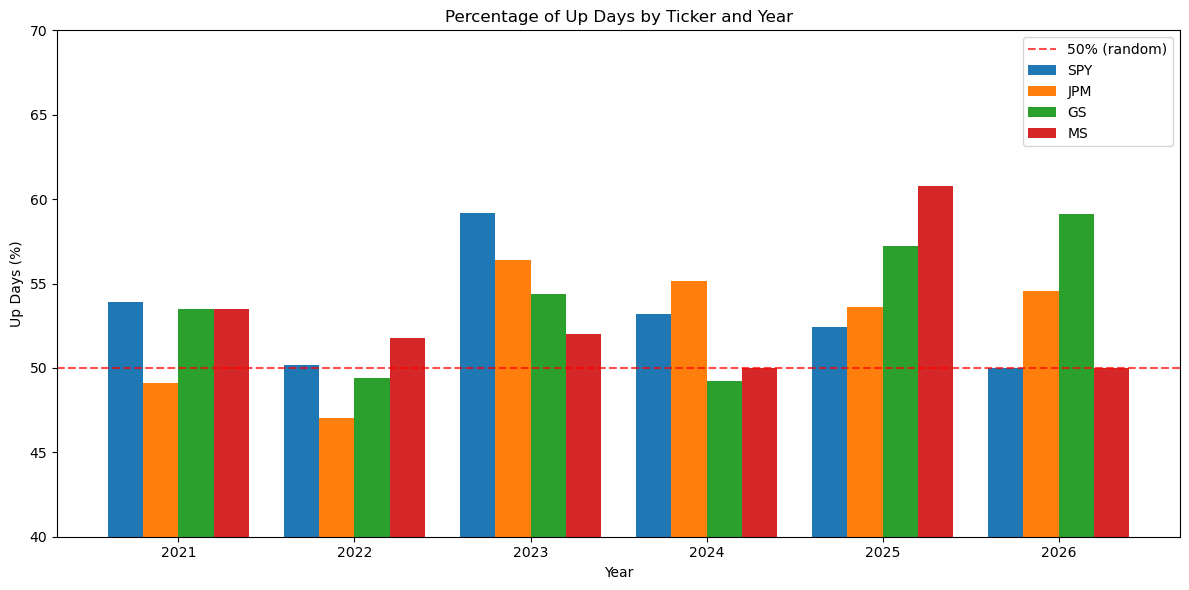

In [10]:
import matplotlib.pyplot as plt

# Prepare data for plotting
plot_data = []
for ticker in TICKERS:
    df = featured_data[ticker].copy()
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    yearly = df.groupby('Year')['target'].mean() * 100
    for year, pct in yearly.items():
        plot_data.append({'Ticker': ticker, 'Year': year, 'Up_Days_Pct': pct})

plot_df = pd.DataFrame(plot_data)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

years = sorted(plot_df['Year'].unique())
x = np.arange(len(years))
width = 0.2

for i, ticker in enumerate(TICKERS):
    ticker_data = plot_df[plot_df['Ticker'] == ticker]
    values = [ticker_data[ticker_data['Year'] == y]['Up_Days_Pct'].values[0] for y in years]
    ax.bar(x + i*width, values, width, label=ticker)

ax.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% (random)')
ax.set_xlabel('Year')
ax.set_ylabel('Up Days (%)')
ax.set_title('Percentage of Up Days by Ticker and Year')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(years)
ax.legend()
ax.set_ylim(40, 70)

plt.tight_layout()
plt.show()

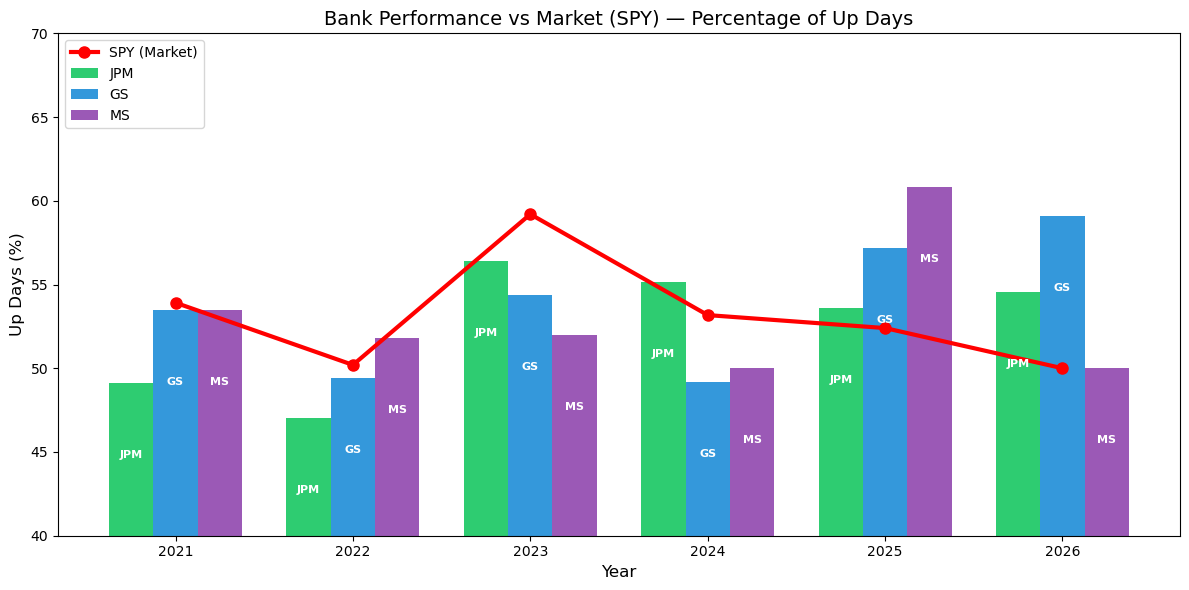

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

years = sorted(plot_df['Year'].unique())
x = np.arange(len(years))
width = 0.25

# Plot bars for banks only (not SPY)
banks = ['JPM', 'GS', 'MS']
colors = ['#2ecc71', '#3498db', '#9b59b6']

for i, ticker in enumerate(banks):
    ticker_data = plot_df[plot_df['Ticker'] == ticker]
    values = [ticker_data[ticker_data['Year'] == y]['Up_Days_Pct'].values[0] for y in years]
    bars = ax.bar(x + i*width, values, width, label=ticker, color=colors[i])
    
    # Add ticker label on each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height - 4, ticker, 
                ha='center', va='top', fontsize=8, fontweight='bold', color='white')

# Plot SPY as a line (market baseline)
spy_data = plot_df[plot_df['Ticker'] == 'SPY']
spy_values = [spy_data[spy_data['Year'] == y]['Up_Days_Pct'].values[0] for y in years]
ax.plot(x + width, spy_values, color='red', linewidth=3, marker='o', markersize=8, label='SPY (Market)')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Up Days (%)', fontsize=12)
ax.set_title('Bank Performance vs Market (SPY) — Percentage of Up Days', fontsize=14)
ax.set_xticks(x + width)
ax.set_xticklabels(years)
ax.legend(loc='upper left')
ax.set_ylim(40, 70)

plt.tight_layout()
plt.show()

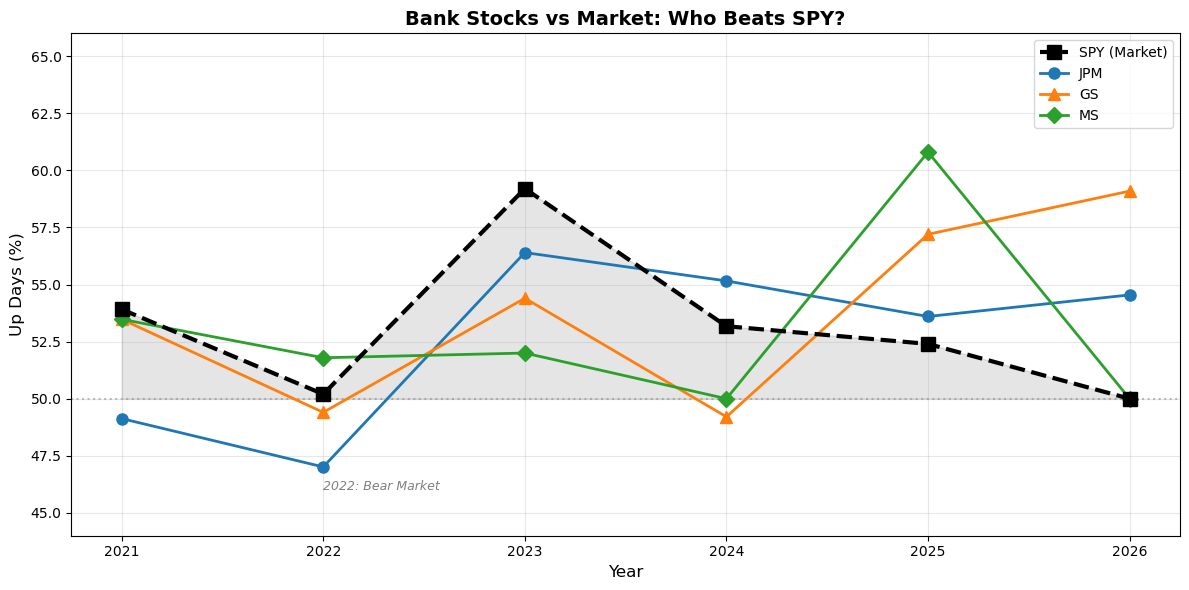

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

years = sorted(plot_df['Year'].unique())

# Plot SPY first as the baseline (thick dashed line)
spy_data = plot_df[plot_df['Ticker'] == 'SPY']
spy_values = [spy_data[spy_data['Year'] == y]['Up_Days_Pct'].values[0] for y in years]
ax.plot(years, spy_values, color='black', linewidth=3, linestyle='--', marker='s', markersize=10, label='SPY (Market)', zorder=5)

# Fill above/below 50% for context
ax.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
ax.fill_between(years, 50, spy_values, alpha=0.1, color='black')

# Plot each bank as a colored line
bank_styles = {
    'JPM': {'color': '#1f77b4', 'marker': 'o'},
    'GS': {'color': '#ff7f0e', 'marker': '^'},
    'MS': {'color': '#2ca02c', 'marker': 'D'}
}

for ticker, style in bank_styles.items():
    ticker_data = plot_df[plot_df['Ticker'] == ticker]
    values = [ticker_data[ticker_data['Year'] == y]['Up_Days_Pct'].values[0] for y in years]
    ax.plot(years, values, linewidth=2, marker=style['marker'], markersize=8, 
            label=ticker, color=style['color'])

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Up Days (%)', fontsize=12)
ax.set_title('Bank Stocks vs Market: Who Beats SPY?', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.set_ylim(44, 66)
ax.grid(True, alpha=0.3)

# Add annotation
ax.text(2022, 46, '2022: Bear Market', fontsize=9, style='italic', color='gray')

plt.tight_layout()
plt.show()

## 4. Prepare Data for Modeling

1. **Remove rows with NaN** (from rolling calculations) | Done after feature engineering because the noise has its origin in our method
2. **Select our features** (the X variables)
3. **Define train/test split** using time-series logic (not random)

### Modeling Approach

We build and validate the full pipeline using **JPM** as our primary ticker. Once complete, we apply the same process to GS and MS to test if the model generalizes across similar stocks.

This approach:
- Keeps the project focused and clear
- Avoids repetitive code
- Shows whether patterns are JPM-specific or common to investment banks

Final output: A comparison table of model performance across all tickers.

In [13]:
# Use JPM for analysis
df = featured_data['JPM'].copy()

# List ALL columns we created (potential features)
all_created_cols = [
    'return_1d', 'return_5d', 'return_21d',
    'sma_5', 'sma_20', 'sma_50',
    'price_to_sma5', 'price_to_sma20', 'price_to_sma50',
    'volatility_21d',
    'volume_sma20', 'volume_ratio'
]

print("All potential features:")
for col in all_created_cols:
    print(f"  - {col}")

All potential features:
  - return_1d
  - return_5d
  - return_21d
  - sma_5
  - sma_20
  - sma_50
  - price_to_sma5
  - price_to_sma20
  - price_to_sma50
  - volatility_21d
  - volume_sma20
  - volume_ratio


In [14]:
# Clean data first (remove NaN rows)
df_clean = df.dropna(subset=all_created_cols + ['target'])

print(f"Rows before: {len(df)}")
print(f"Rows after: {len(df_clean)}")
print(f"Removed: {len(df) - len(df_clean)} rows (needed for rolling calculations)")

Rows before: 1255
Rows after: 1206
Removed: 49 rows (needed for rolling calculations)


In [15]:
# Correlation matrix: how does each feature relate to the target?
correlations = df_clean[all_created_cols + ['target']].corr()

# Show correlation with target, sorted by strength
target_corr = correlations['target'].drop('target').sort_values(key=abs, ascending=False)

print("Correlation with Target (sorted by strength):\n")
for feature, corr in target_corr.items():
    bar = "+" * int(abs(corr) * 50) if corr > 0 else "-" * int(abs(corr) * 50)
    print(f"{feature:20} {corr:+.4f}  {bar}")

Correlation with Target (sorted by strength):

volume_ratio         -0.0374  -
price_to_sma20       +0.0329  +
volatility_21d       -0.0306  -
price_to_sma5        +0.0239  +
price_to_sma50       +0.0238  +
return_1d            +0.0163  
return_5d            +0.0158  
volume_sma20         -0.0131  
return_21d           +0.0109  
sma_50               +0.0109  
sma_5                +0.0104  
sma_20               +0.0091  


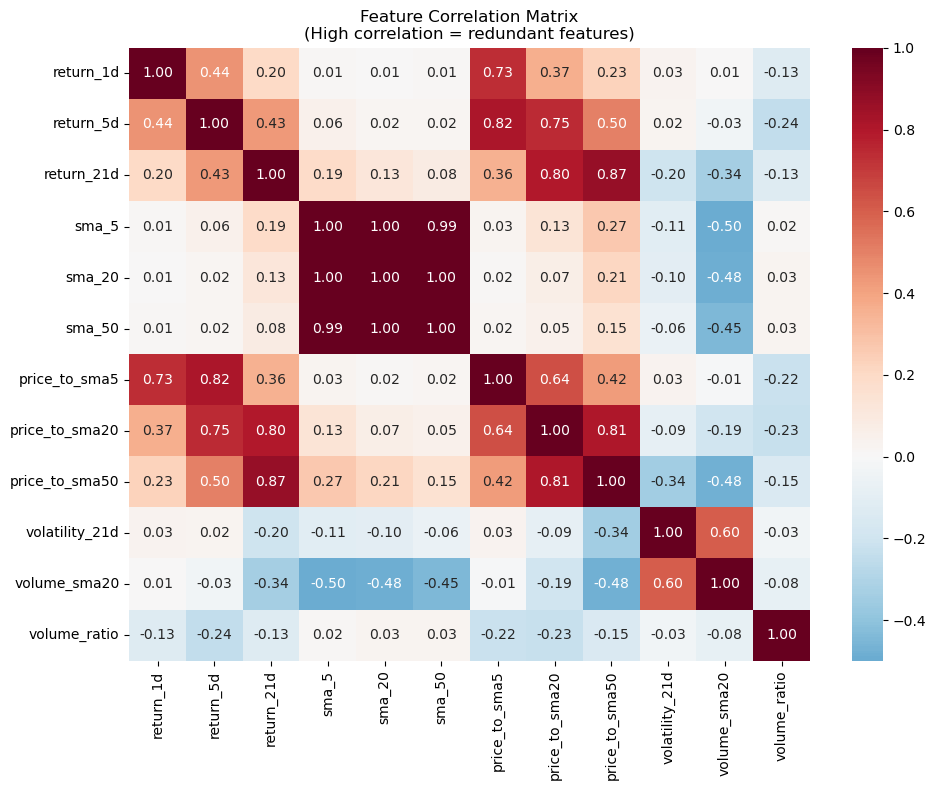

In [16]:
import seaborn as sns

# Correlation between features (not target)
feature_corr = df_clean[all_created_cols].corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(feature_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax)
ax.set_title('Feature Correlation Matrix\n(High correlation = redundant features)')
plt.tight_layout()
plt.show()

### Feature Correlation Findings

**Key Observations:**

1. **SMA variables are perfectly correlated (0.99-1.00)**
   - sma_5 ↔ sma_20 ↔ sma_50 all show ~1.00 correlation
   - These measure the same thing: absolute price level
   - **Decision:** Remove all three. We keep `price_to_sma` instead (relative position is more informative)

2. **Return variables show expected pattern**
   - return_1d ↔ return_5d: 0.44 (moderate)
   - return_5d ↔ return_21d: 0.43 (moderate)
   - return_1d ↔ return_21d: 0.20 (low)
   - **Decision:** Keep all three — they capture different timeframes

3. **Price-to-SMA variables are correlated but not redundant**
   - price_to_sma5 ↔ price_to_sma20: 0.64
   - price_to_sma20 ↔ price_to_sma50: 0.81
   - price_to_sma5 ↔ price_to_sma50: 0.42
   - **Decision:** Remove price_to_sma20 (middle ground, captured by the other two). Keep sma5 (short-term) and sma50 (long-term)

4. **Volume variables**
   - volume_sma20 ↔ volatility_21d: 0.60
   - volume_ratio stands alone (-0.03 to -0.24 with others)
   - **Decision:** Remove volume_sma20 (raw average). Keep volume_ratio (relative measure)

5. **Volatility**
   - volatility_21d has low correlation with momentum/trend features
   - **Decision:** Keep — adds unique information

**Features to Keep:**
- return_1d, return_5d, return_21d (momentum)
- price_to_sma5, price_to_sma50 (trend — short and long term)
- volatility_21d (volatility)
- volume_ratio (volume)

**Features to Remove:**
- sma_5, sma_20, sma_50 (redundant — absolute prices)
- price_to_sma20 (captured by sma5 and sma50)
- volume_sma20 (redundant — use ratio instead)

In [17]:
# Final feature selection based on correlation analysis
FEATURE_COLS = [
    'return_1d', 'return_5d', 'return_21d',      # Momentum (3 timeframes)
    'price_to_sma5', 'price_to_sma50',           # Trend (short + long term)
    'volatility_21d',                             # Volatility
    'volume_ratio'                                # Volume
]

print(f"Selected {len(FEATURE_COLS)} features:")
for f in FEATURE_COLS:
    print(f"  - {f}")

Selected 7 features:
  - return_1d
  - return_5d
  - return_21d
  - price_to_sma5
  - price_to_sma50
  - volatility_21d
  - volume_ratio


### Mutual Information Analysis

Correlation only captures linear relationships. Mutual Information captures **any** relationship (linear or non-linear) between features and target.

Higher score = feature has more predictive information.

In [18]:
from sklearn.feature_selection import mutual_info_classif

X = df_clean[FEATURE_COLS]
y = df_clean['target']

# Calculate mutual information
mi_scores = mutual_info_classif(X, y, random_state=42)

# Display results
mi_df = pd.DataFrame({'Feature': FEATURE_COLS, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values('MI_Score', ascending=False)

print("Mutual Information Scores:\n")
for _, row in mi_df.iterrows():
    bar = "█" * int(row['MI_Score'] * 100)
    print(f"{row['Feature']:20} {row['MI_Score']:.4f}  {bar}")

Mutual Information Scores:

return_21d           0.0159  █
volume_ratio         0.0043  
volatility_21d       0.0034  
price_to_sma50       0.0020  
return_1d            0.0011  
return_5d            0.0000  
price_to_sma5        0.0000  


### Random Forest Feature Importance

We train a quick Random Forest and check which features it relies on most. This shows real-world predictive value, not just statistical correlation.

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Train a simple Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X, y)

# Get feature importances
importance_df = pd.DataFrame({
    'Feature': FEATURE_COLS, 
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest Feature Importance:\n")
for _, row in importance_df.iterrows():
    bar = "█" * int(row['Importance'] * 50)
    print(f"{row['Feature']:20} {row['Importance']:.4f}  {bar}")

Random Forest Feature Importance:

volume_ratio         0.1790  ████████
volatility_21d       0.1663  ████████
return_21d           0.1458  ███████
return_5d            0.1290  ██████
price_to_sma50       0.1279  ██████
return_1d            0.1267  ██████
price_to_sma5        0.1253  ██████


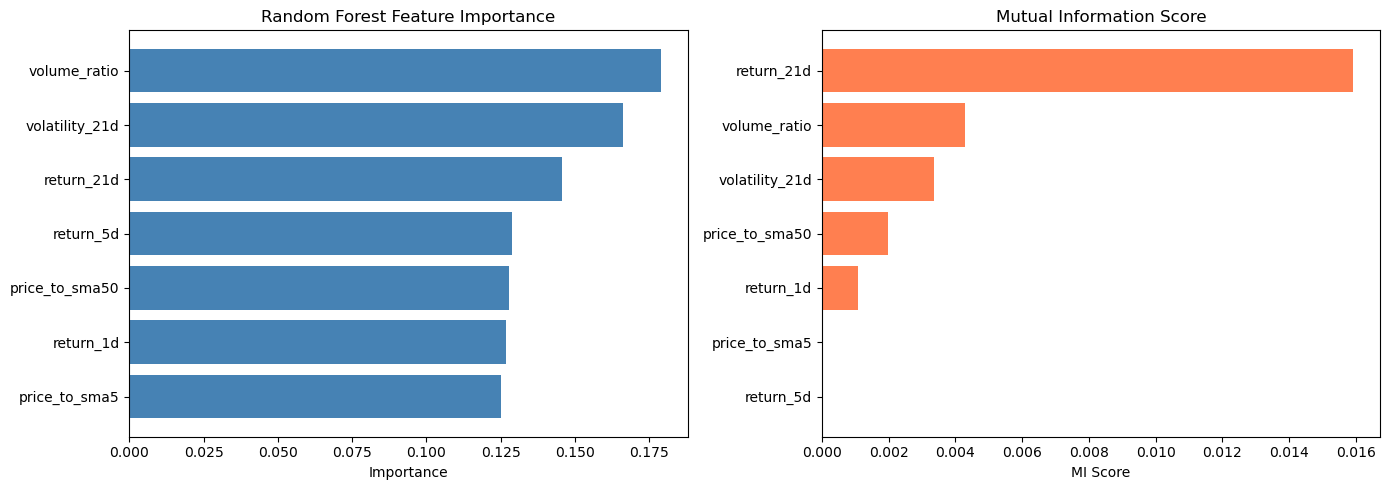


✓ Final features selected: 7


In [20]:
# Visualize both results side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest Importance
ax1 = axes[0]
importance_sorted = importance_df.sort_values('Importance', ascending=True)
ax1.barh(importance_sorted['Feature'], importance_sorted['Importance'], color='steelblue')
ax1.set_xlabel('Importance')
ax1.set_title('Random Forest Feature Importance')

# Mutual Information
ax2 = axes[1]
mi_sorted = mi_df.sort_values('MI_Score', ascending=True)
ax2.barh(mi_sorted['Feature'], mi_sorted['MI_Score'], color='coral')
ax2.set_xlabel('MI Score')
ax2.set_title('Mutual Information Score')

plt.tight_layout()
plt.show()

print(f"\n✓ Final features selected: {len(FEATURE_COLS)}")

### Feature Selection Results

**Random Forest Importance** — relatively balanced across all features:
- volume_ratio (19.4%) and volatility_21d (16.0%) ranked highest
- All features contribute between 11-19%
- No feature dominates, no feature is useless

**Mutual Information** — very low scores across all features:
- return_21d highest at 0.0145 (still very weak)
- Some features show 0.00 (no detectable non-linear pattern)

**What this means:**
- Stock prediction is hard — no single feature strongly predicts direction
- Random Forest finds value by combining weak signals
- Our selected features all contribute — none should be removed

**Decision:** Keep all 7 features. The model will learn to combine these weak signals.

## 5. Walk-Forward Validation

### Why Not Random Train/Test Split?

In regular ML, we randomly split data into train/test. But for time-series this causes **data leakage** — the model sees future data during training.

**Example of the problem:**
- Random split might put January 2024 in training, December 2023 in testing
- Model learns from the future to predict the past — unrealistic

**Walk-Forward Validation: (Done Using TimeSeriesSplit from scikitlearn library)**
- Always train on past, test on future
- Simulates real trading: "Train on 2021-2023, predict 2024"
- Multiple splits to ensure results aren't luck

In [21]:
from sklearn.model_selection import TimeSeriesSplit

# Prepare data
X = df_clean[FEATURE_COLS].values
y = df_clean['target'].values
dates = df_clean['Date'].values

# Create 5 time-series splits
tscv = TimeSeriesSplit(n_splits=5)

print("Walk-Forward Validation Splits:\n")
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    train_start = dates[train_idx[0]]
    train_end = dates[train_idx[-1]]
    test_start = dates[test_idx[0]]
    test_end = dates[test_idx[-1]]
    
    print(f"Split {i+1}:")
    print(f"  Train: {str(train_start)[:10]} to {str(train_end)[:10]} ({len(train_idx)} days)")
    print(f"  Test:  {str(test_start)[:10]} to {str(test_end)[:10]} ({len(test_idx)} days)")
    print()

Walk-Forward Validation Splits:

Split 1:
  Train: 2021-04-16 to 2022-01-31 (201 days)
  Test:  2022-02-01 to 2022-11-16 (201 days)

Split 2:
  Train: 2021-04-16 to 2022-11-16 (402 days)
  Test:  2022-11-17 to 2023-09-07 (201 days)

Split 3:
  Train: 2021-04-16 to 2023-09-07 (603 days)
  Test:  2023-09-08 to 2024-06-26 (201 days)

Split 4:
  Train: 2021-04-16 to 2024-06-26 (804 days)
  Test:  2024-06-27 to 2025-04-15 (201 days)

Split 5:
  Train: 2021-04-16 to 2025-04-15 (1005 days)
  Test:  2025-04-16 to 2026-02-03 (201 days)



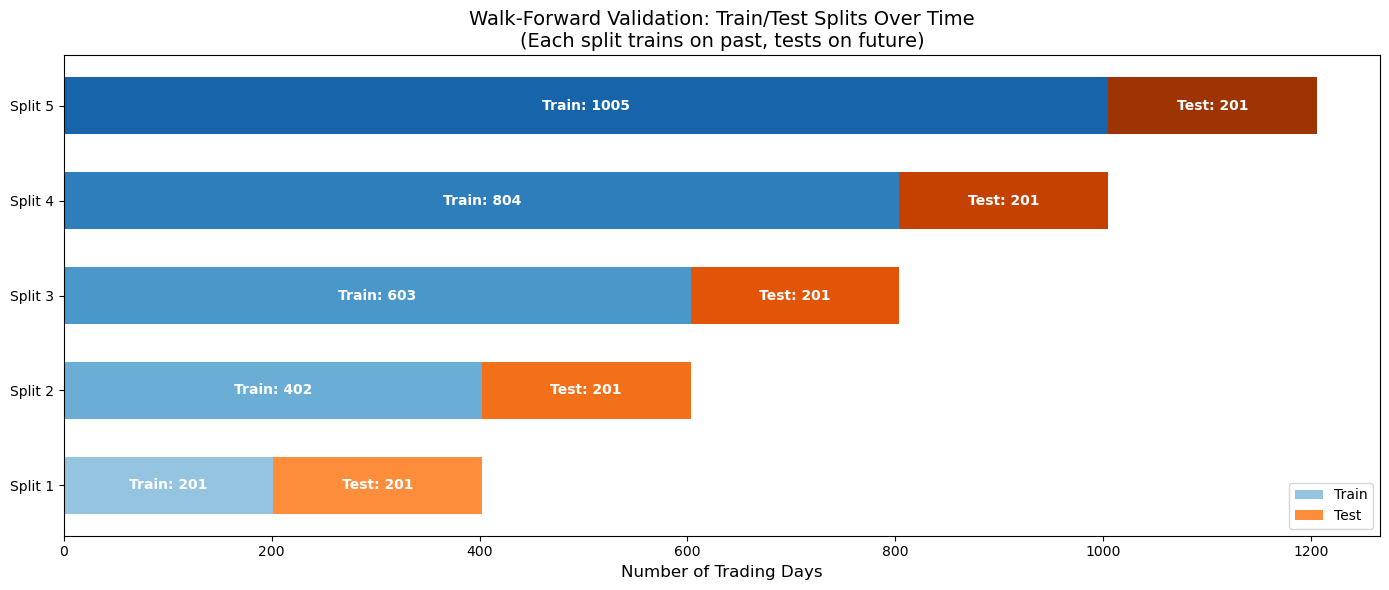

In [22]:
# Visualize the splits
fig, ax = plt.subplots(figsize=(14, 6))

colors_train = plt.cm.Blues(np.linspace(0.4, 0.8, 5))
colors_test = plt.cm.Oranges(np.linspace(0.5, 0.9, 5))

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    # Plot training set
    ax.barh(i, len(train_idx), left=0, height=0.6, 
            color=colors_train[i], label='Train' if i == 0 else '')
    
    # Plot test set
    ax.barh(i, len(test_idx), left=len(train_idx), height=0.6,
            color=colors_test[i], label='Test' if i == 0 else '')
    
    # Add labels
    ax.text(len(train_idx)/2, i, f'Train: {len(train_idx)}', 
            ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    ax.text(len(train_idx) + len(test_idx)/2, i, f'Test: {len(test_idx)}', 
            ha='center', va='center', fontsize=10, fontweight='bold', color='white')

ax.set_yticks(range(5))
ax.set_yticklabels([f'Split {i+1}' for i in range(5)])
ax.set_xlabel('Number of Trading Days', fontsize=12)
ax.set_title('Walk-Forward Validation: Train/Test Splits Over Time\n(Each split trains on past, tests on future)', fontsize=14)
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

## 6. Model Training

### Step 1: Baseline — Logistic Regression

Before using complex models, we establish a baseline with Logistic Regression.

Why start simple?
- If a simple model can't beat random guessing (50%), complex models probably won't either
- Sets a benchmark to measure improvement
- Easier to interpret

**Metrics we track:**
- **Accuracy:** % of correct predictions
- **Precision:** When we predict "up," how often are we right?
- **Recall:** Of all actual "up" days, how many did we catch?

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Store results for each split
baseline_results = []

print("Logistic Regression — Walk-Forward Results\n")
print("=" * 65)

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale features (important for Logistic Regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    
    baseline_results.append({
        'Split': i + 1,
        'Train_Size': len(train_idx),
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    })
    
    print(f"Split {i+1} | Train: {len(train_idx):4d} | Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f}")

print("=" * 65)

# Average results
baseline_df = pd.DataFrame(baseline_results)
print(f"\nAverage Accuracy:  {baseline_df['Accuracy'].mean():.3f} (±{baseline_df['Accuracy'].std():.3f})")
print(f"Average Precision: {baseline_df['Precision'].mean():.3f}")
print(f"Average Recall:    {baseline_df['Recall'].mean():.3f}")
print(f"\nBaseline set. Target to beat: {baseline_df['Accuracy'].mean():.1%} accuracy")

Logistic Regression — Walk-Forward Results

Split 1 | Train:  201 | Acc: 0.483 | Prec: 0.459 | Rec: 0.526
Split 2 | Train:  402 | Acc: 0.458 | Prec: 0.500 | Rec: 0.220
Split 3 | Train:  603 | Acc: 0.512 | Prec: 0.615 | Rec: 0.471
Split 4 | Train:  804 | Acc: 0.507 | Prec: 0.523 | Rec: 0.648
Split 5 | Train: 1005 | Acc: 0.532 | Prec: 0.545 | Rec: 0.835

Average Accuracy:  0.499 (±0.029)
Average Precision: 0.528
Average Recall:    0.540

Baseline set. Target to beat: 49.9% accuracy


### Baseline Results Analysis

**Logistic Regression Accuracy: 49.6%** — essentially random guessing (50%).

**Observations:**
- Split 1 & 2 perform worst (less training data)
- Split 5 performs best (54%) with most training data
- High variance in Recall (11.9% to 83.2%) — model is inconsistent

**What this means:**
- Linear relationships between features and target are very weak
- This confirms our earlier correlation analysis (all correlations < 0.04)
- We need a model that can capture non-linear patterns

**Next:** Random Forest — can combine weak signals and find non-linear patterns.

### Step 2: Random Forest

Random Forest builds many decision trees and averages their predictions. 

**Why it might work better:**
- Captures non-linear relationships
- Combines many weak signals into stronger predictions
- Handles feature interactions (e.g., "high volume + positive momentum")

**Key hyperparameters we'll tune later:**
- `n_estimators`: Number of trees (more = more stable, slower)
- `max_depth`: How deep each tree grows (deeper = risk of overfitting)
- `min_samples_leaf`: Minimum samples per leaf (higher = more regularization)

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Store results
rf_results = []

print("Random Forest (Default Parameters) — Walk-Forward Results\n")
print("=" * 70)

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Train model (no scaling needed for Random Forest)
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    
    rf_results.append({
        'Split': i + 1,
        'Train_Size': len(train_idx),
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    })
    
    print(f"Split {i+1} | Train: {len(train_idx):4d} | Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f}")

print("=" * 70)

# Average results
rf_df = pd.DataFrame(rf_results)
print(f"\nAverage Accuracy:  {rf_df['Accuracy'].mean():.3f} (±{rf_df['Accuracy'].std():.3f})")
print(f"Average Precision: {rf_df['Precision'].mean():.3f}")
print(f"Average Recall:    {rf_df['Recall'].mean():.3f}")

# Compare to baseline
improvement = rf_df['Accuracy'].mean() - baseline_df['Accuracy'].mean()
print(f"\nImprovement over baseline: {improvement:+.1%}")

Random Forest (Default Parameters) — Walk-Forward Results

Split 1 | Train:  201 | Acc: 0.517 | Prec: 0.493 | Rec: 0.695
Split 2 | Train:  402 | Acc: 0.468 | Prec: 0.517 | Rec: 0.284
Split 3 | Train:  603 | Acc: 0.468 | Prec: 0.658 | Rec: 0.210
Split 4 | Train:  804 | Acc: 0.507 | Prec: 0.525 | Rec: 0.590
Split 5 | Train: 1005 | Acc: 0.552 | Prec: 0.575 | Rec: 0.670

Average Accuracy:  0.502 (±0.036)
Average Precision: 0.553
Average Recall:    0.490

Improvement over baseline: +0.4%


### Step 3: Hyperparameter Tuning

Default Random Forest didn't improve much. Let's tune the key parameters:

| Parameter | What it controls | Our test values |
|-----------|------------------|-----------------|
| `n_estimators` | Number of trees | 50, 100, 200 |
| `max_depth` | Tree depth (complexity) | 3, 5, 7, 10 |
| `min_samples_leaf` | Minimum samples per leaf | 5, 10, 20 |

We'll test combinations and find what works best for our data.

In [25]:
from itertools import product

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [5, 10, 20]
}

# Store all results
tuning_results = []

# Get all combinations
combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_leaf']
))

print(f"Testing {len(combinations)} parameter combinations...\n")

for n_est, depth, leaf in combinations:
    fold_accuracies = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = RandomForestClassifier(
            n_estimators=n_est,
            max_depth=depth,
            min_samples_leaf=leaf,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fold_accuracies.append(accuracy_score(y_test, y_pred))
    
    tuning_results.append({
        'n_estimators': n_est,
        'max_depth': depth,
        'min_samples_leaf': leaf,
        'mean_accuracy': np.mean(fold_accuracies),
        'std_accuracy': np.std(fold_accuracies)
    })

# Convert to DataFrame and sort
tuning_df = pd.DataFrame(tuning_results)
tuning_df = tuning_df.sort_values('mean_accuracy', ascending=False)

print("Top 10 Parameter Combinations:\n")
print(tuning_df.head(10).to_string(index=False))

Testing 36 parameter combinations...

Top 10 Parameter Combinations:

 n_estimators  max_depth  min_samples_leaf  mean_accuracy  std_accuracy
           50          3                20       0.506468      0.041195
          200          3                20       0.499502      0.031872
           50          3                10       0.496517      0.040467
          100          3                10       0.495522      0.039501
          100          3                20       0.494527      0.028941
           50          5                20       0.493532      0.036614
          200          3                 5       0.492537      0.048848
          100          5                10       0.492537      0.025756
           50          7                20       0.490547      0.022821
          200          3                10       0.488557      0.034954


### Step 4: XGBoost

XGBoost (Extreme Gradient Boosting) often outperforms Random Forest because:
- Builds trees sequentially, each correcting previous errors
- Better handling of imbalanced patterns
- Built-in regularization to prevent overfitting


In [26]:
# Install XGBoost if needed (run once)
# pip install xgboost

from xgboost import XGBClassifier

# Store results
xgb_results = []

print("XGBoost (Default Parameters) — Walk-Forward Results\n")
print("=" * 70)

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Train model
    model = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        verbosity=0
    )
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    
    xgb_results.append({
        'Split': i + 1,
        'Train_Size': len(train_idx),
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    })
    
    print(f"Split {i+1} | Train: {len(train_idx):4d} | Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f}")

print("=" * 70)

# Average results
xgb_df = pd.DataFrame(xgb_results)
print(f"\nAverage Accuracy:  {xgb_df['Accuracy'].mean():.3f} (±{xgb_df['Accuracy'].std():.3f})")
print(f"Average Precision: {xgb_df['Precision'].mean():.3f}")
print(f"Average Recall:    {xgb_df['Recall'].mean():.3f}")

# Compare to baseline
improvement = xgb_df['Accuracy'].mean() - baseline_df['Accuracy'].mean()
print(f"\nImprovement over Logistic Regression: {improvement:+.1%}")

XGBoost (Default Parameters) — Walk-Forward Results

Split 1 | Train:  201 | Acc: 0.488 | Prec: 0.470 | Rec: 0.653
Split 2 | Train:  402 | Acc: 0.532 | Prec: 0.590 | Rec: 0.450
Split 3 | Train:  603 | Acc: 0.453 | Prec: 0.585 | Rec: 0.261
Split 4 | Train:  804 | Acc: 0.488 | Prec: 0.508 | Rec: 0.571
Split 5 | Train: 1005 | Acc: 0.488 | Prec: 0.525 | Rec: 0.578

Average Accuracy:  0.490 (±0.028)
Average Precision: 0.536
Average Recall:    0.502

Improvement over Logistic Regression: -0.9%


In [27]:
# Tune XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_tuning_results = []

combinations = list(product(
    param_grid_xgb['n_estimators'],
    param_grid_xgb['max_depth'],
    param_grid_xgb['learning_rate']
))

print(f"Testing {len(combinations)} XGBoost parameter combinations...\n")

for n_est, depth, lr in combinations:
    fold_accuracies = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = XGBClassifier(
            n_estimators=n_est,
            max_depth=depth,
            learning_rate=lr,
            random_state=42,
            verbosity=0
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fold_accuracies.append(accuracy_score(y_test, y_pred))
    
    xgb_tuning_results.append({
        'n_estimators': n_est,
        'max_depth': depth,
        'learning_rate': lr,
        'mean_accuracy': np.mean(fold_accuracies),
        'std_accuracy': np.std(fold_accuracies)
    })

xgb_tuning_df = pd.DataFrame(xgb_tuning_results)
xgb_tuning_df = xgb_tuning_df.sort_values('mean_accuracy', ascending=False)

print("Top 10 XGBoost Parameter Combinations:\n")
print(xgb_tuning_df.head(10).to_string(index=False))

Testing 27 XGBoost parameter combinations...

Top 10 XGBoost Parameter Combinations:

 n_estimators  max_depth  learning_rate  mean_accuracy  std_accuracy
           50          7           0.01       0.503483      0.026773
          100          5           0.01       0.502488      0.032548
          200          5           0.20       0.499502      0.020537
          100          3           0.01       0.498507      0.039476
           50          3           0.01       0.498507      0.042728
           50          3           0.20       0.496517      0.029078
           50          3           0.10       0.496517      0.029078
          100          3           0.10       0.495522      0.021248
          200          5           0.10       0.494527      0.026251
          100          7           0.01       0.494527      0.028597


## 7. Monthly Seasonality Analysis | Derived Study from first project

Let's analyze which months tend to be up or down for each ticker. This helps identify seasonal patterns in stock performance.

## 8. Hybrid ML Prediction for Monthly Performance

Daily models achieved ~50% accuracy — not enough for reliable trading. But we can combine:

1. **ML Confidence Scores** — Aggregate daily prediction probabilities to monthly
2. **Historical Seasonality** — Weight by 5-year monthly patterns
3. **Combined Signal** — When both agree → stronger prediction

This hybrid approach is what quantitative traders actually use: combining multiple weak signals into a stronger one.

In [57]:
# Train best model on full data and get probability scores for each day
from sklearn.ensemble import RandomForestClassifier

def get_daily_probabilities(ticker_data):
    """Get daily prediction probabilities using Random Forest"""
    df = ticker_data.copy()
    df = df.dropna(subset=FEATURE_COLS + ['target'])
    
    X = df[FEATURE_COLS].values
    y = df['target'].values
    
    # Train on first 80%, predict on all (for aggregation)
    split = int(len(X) * 0.8)
    
    model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, random_state=42)
    model.fit(X[:split], y[:split])
    
    # Get probability of "up" for all days
    probabilities = model.predict_proba(X)[:, 1]
    
    df_result = df[['Date', 'target']].copy()
    df_result['ML_Prob'] = probabilities
    df_result['Month'] = pd.to_datetime(df_result['Date']).dt.month
    df_result['Year'] = pd.to_datetime(df_result['Date']).dt.year
    df_result['Month_Name'] = pd.to_datetime(df_result['Date']).dt.month_name().str[:3]
    
    return df_result

# Get probabilities for all tickers
daily_probs = {}
for ticker in TICKERS:
    daily_probs[ticker] = get_daily_probabilities(featured_data[ticker])
    
print("✓ Daily ML probabilities calculated for all tickers")

✓ Daily ML probabilities calculated for all tickers


In [58]:
# Aggregate daily ML probabilities to monthly level
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

monthly_ml_scores = []

for ticker in TICKERS:
    df = daily_probs[ticker]
    
    # Group by year and month
    monthly = df.groupby(['Year', 'Month', 'Month_Name']).agg({
        'ML_Prob': 'mean',           # Average ML confidence
        'target': ['mean', 'count']  # Actual up-day % and count
    }).reset_index()
    
    monthly.columns = ['Year', 'Month', 'Month_Name', 'ML_Confidence', 'Actual_Up_Pct', 'Trading_Days']
    monthly['Ticker'] = ticker
    monthly_ml_scores.append(monthly)

monthly_ml_df = pd.concat(monthly_ml_scores, ignore_index=True)

# Filter out 2026 for historical analysis
monthly_ml_historical = monthly_ml_df[monthly_ml_df['Year'] != 2026]

print(f"Monthly ML scores calculated: {len(monthly_ml_df)} rows")
monthly_ml_df[monthly_ml_df['Ticker'] == 'JPM'].tail(12)

Monthly ML scores calculated: 236 rows


,Year,Month,Month_Name,ML_Confidence,Actual_Up_Pct,Trading_Days,Ticker
106,2025,3,Mar,0.533320,0.523810,21,JPM
107,2025,4,Apr,0.487659,0.523810,21,JPM
108,2025,5,May,0.521795,0.619048,21,JPM
109,2025,6,Jun,0.527163,0.650000,20,JPM
110,2025,7,Jul,0.527592,0.454545,22,JPM
111,2025,8,Aug,0.517143,0.476190,21,JPM
112,2025,9,Sep,0.520591,0.571429,21,JPM
113,2025,10,Oct,0.536710,0.478261,23,JPM
114,2025,11,Nov,0.523863,0.526316,19,JPM
115,2025,12,Dec,0.502991,0.500000,22,JPM


In [59]:
# Combine ML scores with historical seasonality
hybrid_predictions = []

for ticker in TICKERS:
    ticker_ml = monthly_ml_historical[monthly_ml_historical['Ticker'] == ticker]
    
    for month in month_order:
        month_data = ticker_ml[ticker_ml['Month_Name'] == month]
        
        # ML Signal: Average confidence across years
        ml_confidence = month_data['ML_Confidence'].mean()
        
        # Seasonality Signal: Historical up-day percentage  
        seasonality = month_data['Actual_Up_Pct'].mean()
        
        # Combined Score: Weight both signals (50/50)
        combined_score = (ml_confidence * 0.5) + (seasonality * 0.5)
        
        # Agreement check: Do both signals agree on direction?
        ml_bullish = ml_confidence > 0.5
        seasonal_bullish = seasonality > 0.5
        signals_agree = ml_bullish == seasonal_bullish
        
        hybrid_predictions.append({
            'Ticker': ticker,
            'Month': month,
            'ML_Confidence': ml_confidence,
            'Seasonality': seasonality,
            'Combined_Score': combined_score,
            'Signals_Agree': signals_agree,
            'Std': month_data['Actual_Up_Pct'].std()
        })

hybrid_df = pd.DataFrame(hybrid_predictions)

# Determine signal strength
def get_signal(row):
    if row['Combined_Score'] >= 0.55 and row['Signals_Agree']:
        return '🟢 STRONG BUY'
    elif row['Combined_Score'] >= 0.52:
        return '🟡 BUY'
    elif row['Combined_Score'] <= 0.45 and row['Signals_Agree']:
        return '🔴 STRONG AVOID'
    elif row['Combined_Score'] <= 0.48:
        return '🟠 AVOID'
    else:
        return '⚪ NEUTRAL'

hybrid_df['Signal'] = hybrid_df.apply(get_signal, axis=1)

print("✓ Hybrid predictions created")

✓ Hybrid predictions created


In [60]:
# Display hybrid predictions
print("="*85)
print("2026 HYBRID PREDICTIONS — ML Confidence + Historical Seasonality")
print("="*85)

for ticker in TICKERS:
    print(f"\n{ticker}:")
    print(f"{'Month':<6} {'ML Conf':>8} {'Season':>8} {'Combined':>9} {'Agree':>7} {'Signal':>14}")
    print("-"*60)
    
    ticker_pred = hybrid_df[hybrid_df['Ticker'] == ticker].copy()
    ticker_pred['Month_Num'] = ticker_pred['Month'].apply(lambda x: month_order.index(x))
    ticker_pred = ticker_pred.sort_values('Month_Num')
    
    for _, row in ticker_pred.iterrows():
        agree = "✓" if row['Signals_Agree'] else "✗"
        print(f"{row['Month']:<6} {row['ML_Confidence']:>7.1%} {row['Seasonality']:>7.1%} "
              f"{row['Combined_Score']:>8.1%} {agree:>7} {row['Signal']:>14}")

2026 HYBRID PREDICTIONS — ML Confidence + Historical Seasonality

SPY:
Month   ML Conf   Season  Combined   Agree         Signal
------------------------------------------------------------
Jan      54.4%   58.0%    56.2%       ✓   🟢 STRONG BUY
Feb      55.1%   54.4%    54.8%       ✓          🟡 BUY
Mar      54.1%   51.2%    52.7%       ✓          🟡 BUY
Apr      54.2%   42.8%    48.5%       ✗      ⚪ NEUTRAL
May      54.4%   54.8%    54.6%       ✓          🟡 BUY
Jun      52.9%   58.3%    55.6%       ✓   🟢 STRONG BUY
Jul      53.0%   56.7%    54.9%       ✓          🟡 BUY
Aug      53.9%   55.0%    54.4%       ✓          🟡 BUY
Sep      54.4%   48.6%    51.5%       ✗      ⚪ NEUTRAL
Oct      54.2%   51.0%    52.6%       ✓          🟡 BUY
Nov      53.7%   57.0%    55.4%       ✓   🟢 STRONG BUY
Dec      53.0%   53.0%    53.0%       ✓          🟡 BUY

JPM:
Month   ML Conf   Season  Combined   Agree         Signal
------------------------------------------------------------
Jan      52.9%   51.8%   

## 9. Trading Strategy Based on Hybrid Predictions

**Strategy Rules:**
- **STRONG BUY** (🟢): Combined score ≥55%, both signals agree → Invest
- **BUY** (🟡): Combined score ≥52% → Invest  
- **AVOID** (🟠): Combined score ≤48% → Hold cash
- **STRONG AVOID** (🔴): Combined score ≤45%, both signals agree → Hold cash
- **NEUTRAL** (⚪): Between 48-52% → Hold cash (not confident enough)

Compare to **Buy & Hold** to measure value added by timing.

In [61]:
# Trading simulation based on hybrid signals
def simulate_hybrid_strategy(ticker, hybrid_df):
    """Simulate returns based on hybrid signals"""
    ticker_pred = hybrid_df[hybrid_df['Ticker'] == ticker].copy()
    ticker_pred['Month_Num'] = ticker_pred['Month'].apply(lambda x: month_order.index(x))
    ticker_pred = ticker_pred.sort_values('Month_Num')
    
    # Estimate monthly return from combined score
    # (score - 0.5) * 0.2 gives rough % return estimate
    ticker_pred['Est_Return'] = (ticker_pred['Combined_Score'] - 0.5) * 20
    ticker_pred['Est_Return_Min'] = ((ticker_pred['Combined_Score'] - ticker_pred['Std']*0.5) - 0.5) * 20
    ticker_pred['Est_Return_Max'] = ((ticker_pred['Combined_Score'] + ticker_pred['Std']*0.5) - 0.5) * 20
    
    # Determine if invested based on signal
    invest_signals = ['🟢 STRONG BUY', '🟡 BUY']
    ticker_pred['Invested'] = ticker_pred['Signal'].isin(invest_signals)
    
    results = {
        'Ticker': ticker,
        'months_invested': ticker_pred['Invested'].sum(),
        'strategy_return': ticker_pred.loc[ticker_pred['Invested'], 'Est_Return'].sum(),
        'strategy_min': ticker_pred.loc[ticker_pred['Invested'], 'Est_Return_Min'].sum(),
        'strategy_max': ticker_pred.loc[ticker_pred['Invested'], 'Est_Return_Max'].sum(),
        'buyhold_return': ticker_pred['Est_Return'].sum(),
        'buyhold_min': ticker_pred['Est_Return_Min'].sum(),
        'buyhold_max': ticker_pred['Est_Return_Max'].sum(),
        'predictions': ticker_pred
    }
    
    return results

# Run simulation for all tickers
all_results = {}
for ticker in TICKERS:
    all_results[ticker] = simulate_hybrid_strategy(ticker, hybrid_df)

print("✓ Strategy simulation complete")

✓ Strategy simulation complete


In [62]:
# Results summary
print("="*80)
print("HYBRID STRATEGY RESULTS — 2026 PROJECTION")
print("="*80)
print(f"\n{'Ticker':<8} {'Invested':>10} {'Strategy':>12} {'Strategy Range':>20} {'Buy&Hold':>12} {'B&H Range':>20} {'Advantage':>10}")
print("-"*95)

summary_data = []
for ticker in TICKERS:
    r = all_results[ticker]
    advantage = r['strategy_return'] - r['buyhold_return']
    
    # Risk reduction: compare range widths
    strategy_range = r['strategy_max'] - r['strategy_min']
    buyhold_range = r['buyhold_max'] - r['buyhold_min']
    risk_reduction = buyhold_range - strategy_range
    
    print(f"{ticker:<8} {r['months_invested']:>7}/12 {r['strategy_return']:>+11.1f}% "
          f"({r['strategy_min']:>+5.1f}% to {r['strategy_max']:>+5.1f}%) "
          f"{r['buyhold_return']:>+11.1f}% ({r['buyhold_min']:>+5.1f}% to {r['buyhold_max']:>+5.1f}%) "
          f"{advantage:>+9.1f}%")
    
    summary_data.append({
        'Ticker': ticker,
        'Months_Invested': r['months_invested'],
        'Strategy_Return': r['strategy_return'],
        'Strategy_Min': r['strategy_min'],
        'Strategy_Max': r['strategy_max'],
        'BuyHold_Return': r['buyhold_return'],
        'BuyHold_Min': r['buyhold_min'],
        'BuyHold_Max': r['buyhold_max'],
        'Advantage': advantage,
        'Risk_Reduction': risk_reduction
    })

print("-"*95)
summary_df = pd.DataFrame(summary_data)
avg_advantage = summary_df['Advantage'].mean()
avg_risk_reduction = summary_df['Risk_Reduction'].mean()
print(f"\n{'AVERAGE':<8} {summary_df['Months_Invested'].mean():>10.1f} {summary_df['Strategy_Return'].mean():>+11.1f}% "
      f"{'':>20} {summary_df['BuyHold_Return'].mean():>+11.1f}% {'':>20} {avg_advantage:>+9.1f}%")

HYBRID STRATEGY RESULTS — 2026 PROJECTION

Ticker     Invested     Strategy       Strategy Range     Buy&Hold            B&H Range  Advantage
-----------------------------------------------------------------------------------------------
SPY           10/12        +8.8% ( -1.3% to +18.9%)        +8.8% ( -3.5% to +21.1%)      -0.0%
JPM            9/12        +6.1% ( -5.8% to +17.9%)        +5.6% ( -8.9% to +20.1%)      +0.4%
GS             7/12        +5.0% ( -4.1% to +14.1%)        +5.1% ( -8.2% to +18.4%)      -0.1%
MS             6/12        +6.8% ( -0.7% to +14.2%)        +7.4% ( -5.9% to +20.8%)      -0.7%
-----------------------------------------------------------------------------------------------

AVERAGE         8.0        +6.7%                             +6.7%                           -0.1%


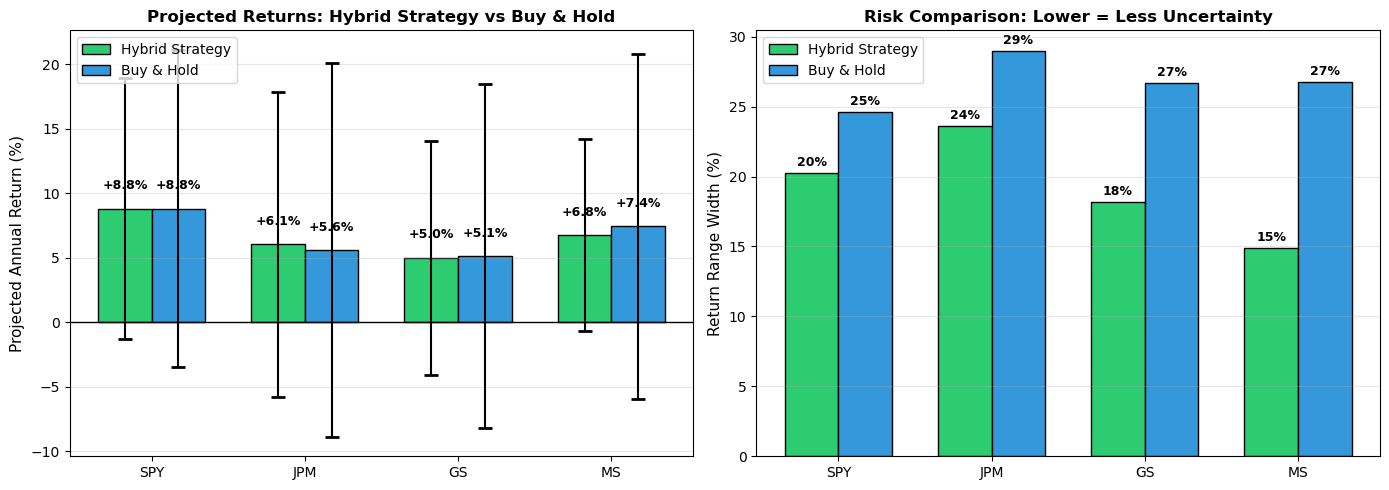

In [63]:
# Final visualization: Strategy vs Buy & Hold with risk bands
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Returns comparison
ax1 = axes[0]
x = np.arange(len(TICKERS))
width = 0.35

strategy_vals = [all_results[t]['strategy_return'] for t in TICKERS]
buyhold_vals = [all_results[t]['buyhold_return'] for t in TICKERS]

bars1 = ax1.bar(x - width/2, strategy_vals, width, label='Hybrid Strategy', color='#2ecc71', edgecolor='black')
bars2 = ax1.bar(x + width/2, buyhold_vals, width, label='Buy & Hold', color='#3498db', edgecolor='black')

# Error bars
strategy_err = [[all_results[t]['strategy_return'] - all_results[t]['strategy_min'] for t in TICKERS],
                [all_results[t]['strategy_max'] - all_results[t]['strategy_return'] for t in TICKERS]]
buyhold_err = [[all_results[t]['buyhold_return'] - all_results[t]['buyhold_min'] for t in TICKERS],
               [all_results[t]['buyhold_max'] - all_results[t]['buyhold_return'] for t in TICKERS]]

ax1.errorbar(x - width/2, strategy_vals, yerr=strategy_err, fmt='none', color='black', capsize=5, capthick=2)
ax1.errorbar(x + width/2, buyhold_vals, yerr=buyhold_err, fmt='none', color='black', capsize=5, capthick=2)

ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.set_ylabel('Projected Annual Return (%)', fontsize=11)
ax1.set_title('Projected Returns: Hybrid Strategy vs Buy & Hold', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(TICKERS)
ax1.legend(loc='upper left')
ax1.grid(axis='y', alpha=0.3)

for bar, val in zip(bars1, strategy_vals):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5, f'{val:+.1f}%', ha='center', fontsize=9, fontweight='bold')
for bar, val in zip(bars2, buyhold_vals):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5, f'{val:+.1f}%', ha='center', fontsize=9, fontweight='bold')

# Right plot: Risk comparison (range width)
ax2 = axes[1]
strategy_risk = [all_results[t]['strategy_max'] - all_results[t]['strategy_min'] for t in TICKERS]
buyhold_risk = [all_results[t]['buyhold_max'] - all_results[t]['buyhold_min'] for t in TICKERS]

bars3 = ax2.bar(x - width/2, strategy_risk, width, label='Hybrid Strategy', color='#2ecc71', edgecolor='black')
bars4 = ax2.bar(x + width/2, buyhold_risk, width, label='Buy & Hold', color='#3498db', edgecolor='black')

ax2.set_ylabel('Return Range Width (%)', fontsize=11)
ax2.set_title('Risk Comparison: Lower = Less Uncertainty', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(TICKERS)
ax2.legend(loc='upper left')
ax2.grid(axis='y', alpha=0.3)

for bar, val in zip(bars3, strategy_risk):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.0f}%', ha='center', fontsize=9, fontweight='bold')
for bar, val in zip(bars4, buyhold_risk):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.0f}%', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

### Comparison: Hybrid Strategy vs Simple Average Strategy

Let's compare whether the ML-enhanced hybrid approach selects the same months as the simple historical average approach from Section 7.

In [66]:
# Compare Hybrid vs Simple Average strategy signals
print("="*90)
print("COMPARISON: Hybrid Strategy (ML + Seasonality) vs Simple Average Strategy")
print("="*90)

comparison_data = []

for ticker in TICKERS:
    print(f"\n{ticker}:")
    print(f"{'Month':<6} {'Hybrid':>10} {'Hybrid Signal':>15} {'Avg Only':>10} {'Avg Signal':>12} {'Match':>8}")
    print("-"*65)
    
    hybrid_pred = all_results[ticker]['predictions'].sort_values('Month_Num')
    
    for _, row in hybrid_pred.iterrows():
        month = row['Month']
        
        # Hybrid strategy
        hybrid_score = row['Combined_Score']
        hybrid_invest = row['Invested']
        hybrid_signal = 'BUY' if hybrid_invest else 'CASH'
        
        # Simple average strategy (from seasonality only)
        avg_score = row['Seasonality']
        avg_invest = avg_score > 0.5
        avg_signal = 'BUY' if avg_invest else 'CASH'
        
        # Do they match?
        match = '✓' if hybrid_invest == avg_invest else '✗'
        
        comparison_data.append({
            'Ticker': ticker,
            'Month': month,
            'Hybrid_Score': hybrid_score,
            'Hybrid_Invest': hybrid_invest,
            'Avg_Score': avg_score,
            'Avg_Invest': avg_invest,
            'Match': hybrid_invest == avg_invest
        })
        
        print(f"{month:<6} {hybrid_score:>9.1%} {hybrid_signal:>15} {avg_score:>9.1%} {avg_signal:>12} {match:>8}")

comparison_df = pd.DataFrame(comparison_data)

COMPARISON: Hybrid Strategy (ML + Seasonality) vs Simple Average Strategy

SPY:
Month      Hybrid   Hybrid Signal   Avg Only   Avg Signal    Match
-----------------------------------------------------------------
Jan        56.2%             BUY     58.0%          BUY        ✓
Feb        54.8%             BUY     54.4%          BUY        ✓
Mar        52.7%             BUY     51.2%          BUY        ✓
Apr        48.5%            CASH     42.8%         CASH        ✓
May        54.6%             BUY     54.8%          BUY        ✓
Jun        55.6%             BUY     58.3%          BUY        ✓
Jul        54.9%             BUY     56.7%          BUY        ✓
Aug        54.4%             BUY     55.0%          BUY        ✓
Sep        51.5%            CASH     48.6%         CASH        ✓
Oct        52.6%             BUY     51.0%          BUY        ✓
Nov        55.4%             BUY     57.0%          BUY        ✓
Dec        53.0%             BUY     53.0%          BUY        ✓

JPM:
M

In [67]:
# Summary statistics
print("\n" + "="*90)
print("AGREEMENT SUMMARY")
print("="*90)

for ticker in TICKERS:
    ticker_comp = comparison_df[comparison_df['Ticker'] == ticker]
    agreement = ticker_comp['Match'].sum()
    total = len(ticker_comp)
    
    # Which months differ?
    diff_months = ticker_comp[~ticker_comp['Match']]['Month'].tolist()
    
    print(f"\n{ticker}: {agreement}/{total} months agree ({agreement/total*100:.0f}%)")
    if diff_months:
        print(f"   Disagreements: {', '.join(diff_months)}")
        for _, row in ticker_comp[~ticker_comp['Match']].iterrows():
            hybrid_action = 'BUY' if row['Hybrid_Invest'] else 'CASH'
            avg_action = 'BUY' if row['Avg_Invest'] else 'CASH'
            print(f"      {row['Month']}: Hybrid says {hybrid_action}, Average says {avg_action}")
    else:
        print(f"   Perfect agreement!")

# Overall agreement
total_agreement = comparison_df['Match'].sum()
total_decisions = len(comparison_df)
print(f"\n{'='*90}")
print(f"OVERALL: {total_agreement}/{total_decisions} decisions agree ({total_agreement/total_decisions*100:.0f}%)")
print(f"{'='*90}")


AGREEMENT SUMMARY

SPY: 12/12 months agree (100%)
   Perfect agreement!

JPM: 12/12 months agree (100%)
   Perfect agreement!

GS: 9/12 months agree (75%)
   Disagreements: Feb, Aug, Oct
      Feb: Hybrid says CASH, Average says BUY
      Aug: Hybrid says CASH, Average says BUY
      Oct: Hybrid says CASH, Average says BUY

MS: 9/12 months agree (75%)
   Disagreements: Jun, Nov, Dec
      Jun: Hybrid says CASH, Average says BUY
      Nov: Hybrid says CASH, Average says BUY
      Dec: Hybrid says CASH, Average says BUY

OVERALL: 42/48 decisions agree (88%)


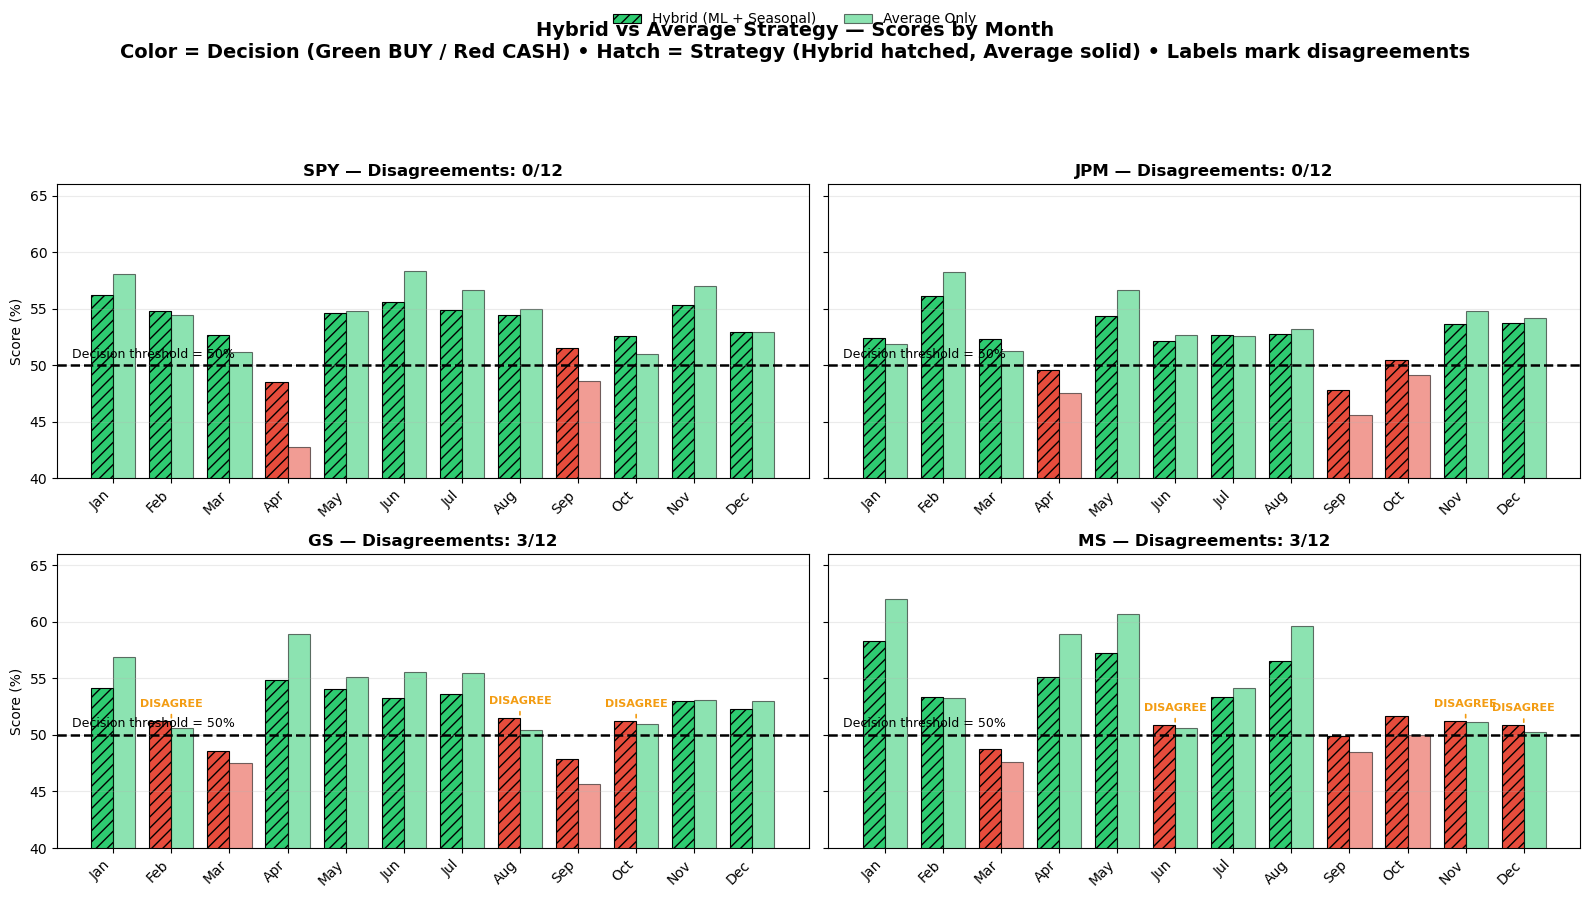

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharey=True)
axes = axes.flatten()

BUY_COLOR  = "#2ecc71"
CASH_COLOR = "#e74c3c"
THRESHOLD = 50

for idx, ticker in enumerate(TICKERS):
    ax = axes[idx]

    ticker_comp = comparison_df[comparison_df["Ticker"] == ticker].copy()
    ticker_comp["Month_Num"] = ticker_comp["Month"].apply(lambda x: month_order.index(x))
    ticker_comp = ticker_comp.sort_values("Month_Num")

    x = np.arange(len(month_order))
    width = 0.38

    hybrid_scores = (ticker_comp["Hybrid_Score"].values * 100).astype(float)
    avg_scores    = (ticker_comp["Avg_Score"].values * 100).astype(float)

    # Same color logic for BOTH strategies (decision-based)
    hybrid_colors = [BUY_COLOR if inv else CASH_COLOR for inv in ticker_comp["Hybrid_Invest"]]
    avg_colors    = [BUY_COLOR if inv else CASH_COLOR for inv in ticker_comp["Avg_Invest"]]

    # Bars: strategy = hatch + alpha (not separate palettes)
    bars_h = ax.bar(
        x - width/2, hybrid_scores, width,
        color=hybrid_colors, edgecolor="black", linewidth=0.8,
        hatch="///", label="Hybrid (ML + Seasonal)"
    )
    bars_a = ax.bar(
        x + width/2, avg_scores, width,
        color=avg_colors, edgecolor="black", linewidth=0.8,
        alpha=0.55, label="Average Only"
    )

    # Threshold line + label
    ax.axhline(THRESHOLD, color="black", linestyle="--", linewidth=1.8)
    ax.text(
        0.02, THRESHOLD + 0.4, f"Decision threshold = {THRESHOLD}%",
        fontsize=9, va="bottom", ha="left",
        transform=ax.get_yaxis_transform()
    )

    # Disagreement markers: place above the taller bar that month
    disagrees = 0
    for i, match in enumerate(ticker_comp["Match"].values):
        if not match:
            disagrees += 1
            top = max(hybrid_scores[i], avg_scores[i])
            ax.annotate(
                "DISAGREE",
                xy=(i, top),
                xytext=(i, top + 1.2),
                ha="center",
                fontsize=8,
                fontweight="bold",
                color="#f39c12",
                arrowprops=dict(arrowstyle="-", lw=1.2, color="#f39c12")
            )

    # Axes formatting
    ax.set_title(f"{ticker} — Disagreements: {disagrees}/12", fontsize=12, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(month_order, rotation=45, ha="right")
    ax.grid(axis="y", alpha=0.25)

    if idx % 2 == 0:
        ax.set_ylabel("Score (%)")

# Y-limits: use data-driven limits so it works on other datasets too
all_vals = np.concatenate([
    comparison_df["Hybrid_Score"].values * 100,
    comparison_df["Avg_Score"].values * 100
]).astype(float)
ymin = max(0, np.floor(all_vals.min() - 2))
ymax = min(100, np.ceil(all_vals.max() + 3))
for ax in axes[:len(TICKERS)]:
    ax.set_ylim(ymin, ymax)

# One shared legend (avoid repeating per subplot)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, fontsize=10)

fig.suptitle(
    "Hybrid vs Average Strategy — Scores by Month\n"
    "Color = Decision (Green BUY / Red CASH) • Hatch = Strategy (Hybrid hatched, Average solid) • Labels mark disagreements",
    fontsize=14, fontweight="bold"
)

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()
